## Multiple revolutions on Lambert's problem

After the implementation of Izzo's algorithm in *poliastro*, it is possible to solve the Lambert's
problem with a multiple revolution solution. Let us remember first what is this problem about and which
applications does it have.

Lambert problem tries to solve the orbit that passes trhough $\vec{r_{0}}$ and $\vec{r_{f}}$ being given an amount of time usually denoted by $\Delta t$. This can be used to solve for interplanetary flights, for example if we know the position of Earth at $t_{0}$ and the position of Mars at time $t_{f}$ we can solve for the orbit that we must follow in order to get to the red planet.

### What are multiple revolutions and why do we care about them?

The basic Lambert algorithm looks for a direc transfer, which can be be a short or long arc transfer as stated by the figure. There exist a total of three orbit solutions defined by the location of the focus for those transfer orbits:

1. **Minimum-energy orbit**: also called the optimal path. In this case the focus lies in the line that conects $\vec{r_{1}}$ and $\vec{r_{2}}$.
2. **Short arc orbit**: both focis $F_{1}$ and $F_{2}^{*}$ of the transfer orbit lie in the same side of the line connecting both position vectors.
3. **Long arc orbit**: each one of the transfer orbit focus lies in a different side of the line connecting both position vectors.

![](lambert_paths.png)

However it is possible to make more than one revolution in order to achieve the target position. So therefore, we end up having a different set of possible transfers depending on:

* A short or long path.
* The number of revolutions, usually denoted by: $M=0$, $M=1$, $M=2$, ...
* Solution number for those revolutions, denoted by: $S_{1}$ and $S_{2}$

Let us see all this combinations by making use of *poliastro*!

In [1]:
from astropy import units as u
from astropy.time import Time

import matplotlib.pyplot as plt

from poliastro.bodies import Sun, Earth, Mars
from poliastro.ephem import Ephem
from poliastro.twobody import Orbit
from poliastro.maneuver import Maneuver
from poliastro.plotting.static import StaticOrbitPlotter
from poliastro.util import time_range

In [2]:
# Departure and time of flight for the mission
EPOCH_DPT = Time("2018-12-01", scale="tdb")
EPOCH_ARR = EPOCH_DPT + 2 * u.year

epochs = time_range(EPOCH_DPT, end=EPOCH_ARR)

# Origin and target orbits
earth = Ephem.from_body(Earth, epochs=epochs)
mars = Ephem.from_body(Mars, epochs=epochs)

earth_departure = Orbit.from_ephem(Sun, earth, EPOCH_DPT)
mars_arrival = Orbit.from_ephem(Sun, mars, EPOCH_ARR)

In [3]:
def lambert_transfer(ss_dpt, ss_arr, revs):
    """ Returns the short and long transfer orbits when solving Lambert's problem.
    
    Parameters
    ----------
    ss_dpt: poliastro.twobody.Orbit
        Deprature orbit.
    ss_arr: poliastro.twobody.Orbit
        Arrival orbit.
    revs: int
        Number of revolutions.
    
    Returns
    -------
    ss_short: poliastro.twobody.Orbit
        Short transfer orbit.
    ss_long: poliastro.twobody.Orbit
        Long transfer orbit.
    """
    
    # Solving for short and long maneuvers
    lambert_short = Maneuver.lambert(earth_departure, mars_arrival, short=True, M=revs)
    lambert_long = Maneuver.lambert(earth_departure, mars_arrival, short=False, M=revs)
    
    # Aplly both maneuvers
    ss_short, _ = ss_dpt.apply_maneuver(lambert_short, intermediate=True)
    ss_long, _ = ss_dpt.apply_maneuver(lambert_long, intermediate=True)

    return ss_short, ss_long

### Solutions for M=0

By making use of the previous defined function, we can easily get the different transfer orbit regarding the number of required revolutions, in this case 0.

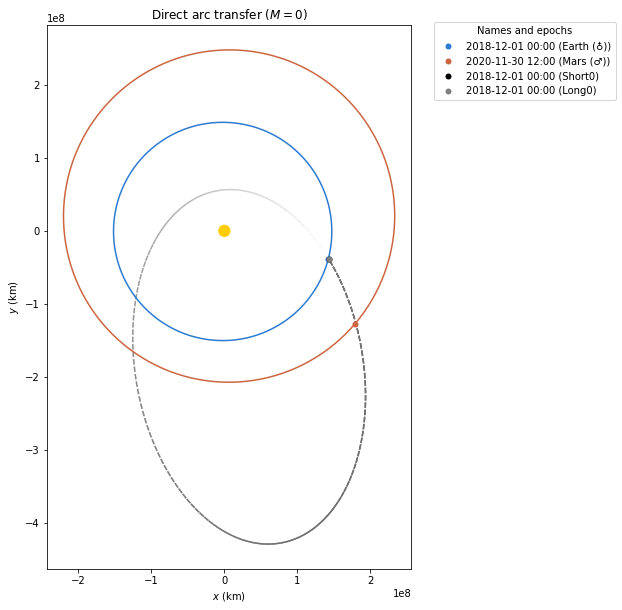

In [4]:
# Solving for direct (M=0) transfer long and short arcs
ss_short0, ss_long0 = lambert_transfer(earth_departure, mars_arrival, revs=0)

fig, ax = plt.subplots(figsize=(5,10))
op = StaticOrbitPlotter(ax=ax)
ax.set_title("Direct arc transfer ($M=0$)")

orbit_set = {ss_short0: ["Short0", "black"],
            ss_long0: ["Long0", "grey"]}

op.plot_body_orbit(Earth, EPOCH_DPT)
op.plot_body_orbit(Mars, EPOCH_ARR)

for ss in orbit_set:
    op.plot(ss, label=orbit_set[ss][0], color=orbit_set[ss][-1], trail=True)

### Solutions for M=1

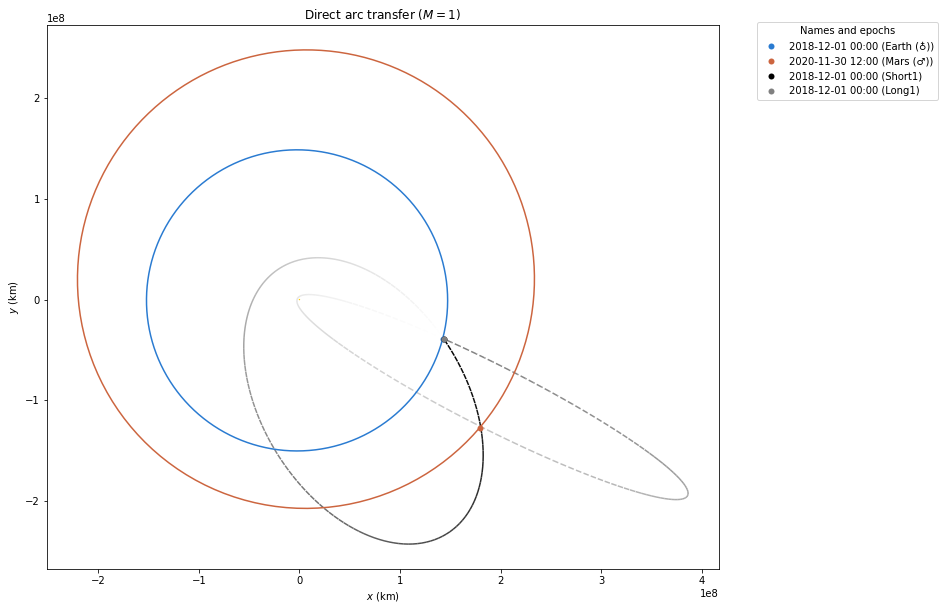

In [5]:
# Solving for M=1 long and short arc transfers
ss_short1, ss_long1 = lambert_transfer(earth_departure, mars_arrival, revs=1)

fig, ax = plt.subplots(figsize=(5,10))
op = StaticOrbitPlotter(ax=ax)
ax.set_title("Direct arc transfer ($M=1$)")

orbit_set = {ss_short1: ["Short1", "black"],
            ss_long1: ["Long1", "grey"]}

op.plot_body_orbit(Earth, EPOCH_DPT)
op.plot_body_orbit(Mars, EPOCH_ARR)

for ss in orbit_set:
    op.plot(ss, label=orbit_set[ss][0], color=orbit_set[ss][-1], trail=True)

### Solutions for M=2

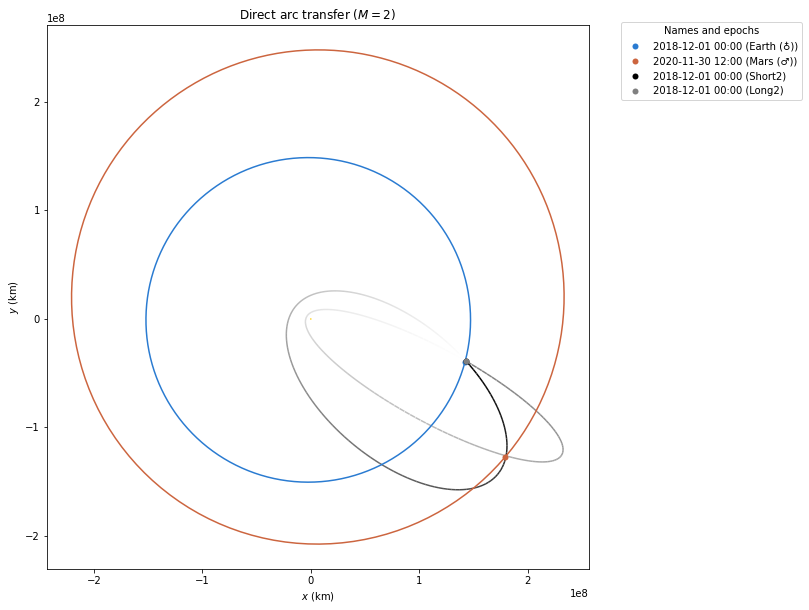

In [6]:
# Solving for M=2 long and short transfer arcs
ss_short2, ss_long2 = lambert_transfer(earth_departure, mars_arrival, revs=2)

fig, ax = plt.subplots(figsize=(5,10))
op = StaticOrbitPlotter(ax=ax)
ax.set_title("Direct arc transfer ($M=2$)")

orbit_set = {ss_short2: ["Short2", "black"],
            ss_long2: ["Long2", "grey"]}

op.plot_body_orbit(Earth, EPOCH_DPT)
op.plot_body_orbit(Mars, EPOCH_ARR)

for ss in orbit_set:
    op.plot(ss, label=orbit_set[ss][0], color=orbit_set[ss][-1], trail=True)

We will plot now all the arc transfers just to better see the difference between them.

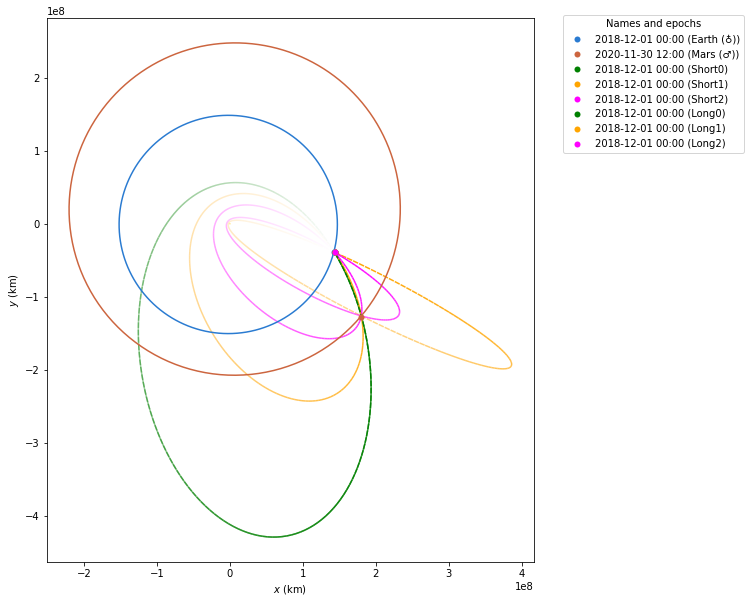

In [7]:
# Plot all solutions together
fig, ax = plt.subplots(figsize=(5,10))
op = StaticOrbitPlotter(ax=ax)
ss_lines = []

orbit_set = {ss_short0: ["Short0", "green", "-."],
            ss_short1: ["Short1", "orange", "-."],
            ss_short2: ["Short2", "magenta", "-."],
            ss_long0: ["Long0", "green", "--"],
            ss_long1: ["Long1", "orange", "--"],
            ss_long2: ["Long2", "magenta", "--"],
            }

op.plot_body_orbit(Earth, EPOCH_DPT)
op.plot_body_orbit(Mars, EPOCH_ARR)

for ss in orbit_set:
    lines = op.plot(ss, label=orbit_set[ss][0], color=orbit_set[ss][1], trail=True)
    lines[0].set_linestyle(orbit_set[ss][-1])